# [](http://)Russian Plate Price Prediction using Ensemble Learning
by Ken Quach
> This code also uses the feature engineering and Autogluon code from [Solomon Andryushenko](https://www.kaggle.com/lumium) and [liangkaixin](https://www.kaggle.com/liangkaixin)

**If my notebook helps you, please consider upvoting it :)**

# Import libraries and download AutoGluon

In [104]:
import os
import sys
import string

import pandas as pd

!pip install autogluon
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.core.metrics import make_scorer

import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bar

import warnings
warnings.filterwarnings('ignore')

# How the plate looks like?

The plate consists of series and number, where the last two or three digits are the region code. Courtesy from [Skoda-storyboard](https://www.skoda-storyboard.com/en/models/deciphering-number-plates-russia/).
![image](https://cdn.skoda-storyboard.com/2019/04/Russian-license-plate-english.jpg#?s_aid=bd5wemcb-uz36-l03s-yigd-6qaeks5bqrk7_004_1)

# Define all functions for feature extraction/engineer

We will use the supplementary files and split the plate characters, then date time...

In [105]:
from supplemental_english import *  # REGION_CODES, GOVERNMENT_CODES


# SMAPE
def smape(y_true, y_pred):
    y_pred = np.exp(y_pred)  
    y_true = np.exp(y_true) 
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100

def find_importance_values_for_plate(plate: str, gov_codes: dict) -> tuple:
    letters = plate[0] + plate[4:6]  # Extracts letters
    numbers = int(plate[1:4])  # Extracts numbers
    region_code = plate[6:]  # Extracts region code

    # print(plate, "---", letters, numbers, region_code)
    
    for (code_letters, num_range, region), details in gov_codes.items():
        if letters == code_letters and region_code == region:
            if num_range[0] <= numbers <= num_range[1]:  # Checks if within range
                return (details[2], details[3])  # Importance values
    
    return (0, 0)  # Ordinary plate, no government affiliation


def add_advantage_on_road_and_significance(data: pd.DataFrame) -> pd.DataFrame:
    def apply_helper(row):
        advantage_on_road, significance = find_importance_values_for_plate(row["plate"], GOVERNMENT_CODES)
        return pd.Series({
            "advantage_on_road": advantage_on_road,
            "significance": significance,
        })

    data[["advantage_on_road", "significance"]] = data.apply(apply_helper, axis=1)
    return data

def encode_plate(plate: str) -> list[int]:
    encoded = []
    for char in plate:
        if char in char2idx:
            encoded.append(char2idx[char])
        else:
            encoded.append(0)
    return encoded

# Define constants
PLATE_POSSIBLE_LETTERS = "ABEKMHOPCTYX"  # 12 total
ALL_CHARS = PLATE_POSSIBLE_LETTERS + string.digits  # 12 + 10 = 22 total
RANDOM_STATE = 37
char2idx = {c: i for i, c in enumerate(ALL_CHARS)}  # char to identifier map

# Data from outside

train dates: 2021-02-17 00:00:00 2025-02-12 00:00:00

test dates: 2021-02-17 00:00:00 2025-02-12 00:00:00

In [106]:
russia_economic_data_2021_2025_with_war_feature_df = pd.read_csv(
    "datasets/russia_economic_data_2021_2025_with_war_feature.csv",

)

russian_holidays_2025_df = pd.read_csv(
    "datasets/russian_holidays_2025.csv",
)

russian_license_plate_market_2021_2025_en_df = pd.read_csv(
    "datasets/russian_license_plate_market_2021_2025_en.csv",
)

In [107]:
russia_economic_data_2021_2025_with_war_feature_df

,Year,Month,Monthly Inflation (%),New Car Sales (units),Fuel Price (RUB/liter),USD/RUB Exchange Rate,Unemployment Rate (%),Public Holidays,Spending on Cars (Billion RUB),Spending on Accessories (Billion RUB),Economic Notes,During_War
0,2021,January,0.84,47099,56.35,77.22,3.29,"1–8: New Year Holidays, 7: Orthodox Christmas",83.45,7.91,Pre-conflict economic conditions,False
1,2021,February,0.93,70660,47.82,74.04,4.37,23: Defender of the Fatherland Day,102.74,9.46,Pre-conflict economic conditions,False
2,2021,March,0.43,81032,53.04,77.35,4.68,8: International Women’s Day,142.62,8.23,Pre-conflict economic conditions,False
3,2021,April,0.86,49340,53.34,79.53,5.74,NaN,69.89,8.38,Pre-conflict economic conditions,False
4,2021,May,0.76,78845,56.51,79.54,4.26,"1: Labor Day, 9: Victory Day",127.28,8.36,Pre-conflict economic conditions,False
5,2021,June,1.10,58457,53.61,90.88,5.24,12: Russia Day,88.06,8.40,Pre-conflict economic conditions,False
6,2021,July,0.77,50986,48.88,82.90,4.72,NaN,72.06,9.03,Pre-conflict economic conditions,False
7,2021,August,0.88,55239,50.91,68.89,4.49,NaN,85.84,9.90,Pre-conflict economic conditions,False
8,2021,September,1.30,65329,47.64,85.79,5.35,NaN,110.24,7.38,Pre-conflict economic conditions,False
9,2021,October,0.51,59152,55.50,88.30,4.76,NaN,86.82,6.54,Pre-conflict economic conditions,False


In [108]:
holiday_dict = [
    {"mm-dd": "01-01", "holiday_name": "New Year Celebrations (Day 1 of 7)", "type": "National"},
    {"mm-dd": "01-02", "holiday_name": "New Year Celebrations (Day 1 of 7)", "type": "National"},
    {"mm-dd": "01-03", "holiday_name": "New Year Celebrations (Day 1 of 7)", "type": "National"},
    {"mm-dd": "01-04", "holiday_name": "New Year Celebrations (Day 1 of 7)", "type": "National"},
    {"mm-dd": "01-05", "holiday_name": "New Year Celebrations (Day 1 of 7)", "type": "National"},
    {"mm-dd": "01-06", "holiday_name": "New Year Celebrations (Day 1 of 7)", "type": "National"},
    {"mm-dd": "01-07", "holiday_name": "New Year Celebrations (Day 1 of 7)", "type": "National"},
    {"mm-dd": "01-07", "holiday_name": "Orthodox Christmas", "type": "Religious"},
    {"mm-dd": "02-23", "holiday_name": "Defender of the Fatherland Day", "type": "National"},
    {"mm-dd": "03-08", "holiday_name": "International Women's Day", "type": "National"},
    {"mm-dd": "05-01", "holiday_name": "Spring and Labor Day", "type": "National"},
    {"mm-dd": "05-09", "holiday_name": "Victory Day", "type": "National"},
    {"mm-dd": "06-12", "holiday_name": "Russia Day", "type": "National"},
    {"mm-dd": "11-04", "holiday_name": "National Unity Day", "type": "National"}
]


In [109]:
# Step 1: Convert holiday_dict to a DataFrame
holiday_df = pd.DataFrame(holiday_dict)

# Step 2: Create a column with 1s for one-hot encoding
holiday_df['value'] = 1

# Step 3: Pivot for one-hot encoding by holiday_name
holiday_ohe = holiday_df.pivot_table(index='mm-dd', 
                                     columns='holiday_name', 
                                     values='value', 
                                     fill_value=0).reset_index()

holiday_ohe

holiday_name,mm-dd,Defender of the Fatherland Day,International Women's Day,National Unity Day,New Year Celebrations (Day 1 of 7),Orthodox Christmas,Russia Day,Spring and Labor Day,Victory Day
0,01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,01-02,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,01-03,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,01-04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,01-05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,01-06,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,01-07,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7,02-23,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,03-08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,05-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [110]:
russia_inflation = {
  "2025-01": 0.10,
  "2025-02": 0.101,
  "2024-01": 0.074,
  "2024-02": 0.077,
  "2024-03": 0.077,
  "2024-04": 0.078,
  "2024-05": 0.083,
  "2024-06": 0.087,
  "2024-07": 0.092,
  "2024-08": 0.091,
  "2024-09": 0.086,
  "2024-10": 0.085,
  "2024-11": 0.089,
  "2024-12": 0.095,
  "2023-01": 0.118,
  "2023-02": 0.110,
  "2023-03": 0.035,
  "2023-04": 0.023,
  "2023-05": 0.025,
  "2023-06": 0.032,
  "2023-07": 0.042,
  "2023-08": 0.052,
  "2023-09": 0.060,
  "2023-10": 0.067,
  "2023-11": 0.075,
  "2023-12": 0.074,
  "2022-01": 0.087,
  "2022-02": 0.092,
  "2022-03": 0.167,
  "2022-04": 0.179,
  "2022-05": 0.171,
  "2022-06": 0.159,
  "2022-07": 0.151,
  "2022-08": 0.143,
  "2022-09": 0.136,
  "2022-10": 0.126,
  "2022-11": 0.119,
  "2022-12": 0.119,
  "2021-01": 0.052,
  "2021-02": 0.057,
  "2021-03": 0.058,
  "2021-04": 0.055,
  "2021-05": 0.060,
  "2021-06": 0.065,
  "2021-07": 0.065,
  "2021-08": 0.067,
  "2021-09": 0.074,
  "2021-10": 0.081,
  "2021-11": 0.084,
  "2021-12": 0.084}

In [111]:
USD_RUB_Historical_Data = pd.read_csv(
    "datasets/USD_RUB Historical Data.csv",
)

USD_RUB_Historical_Data['Date'] = pd.to_datetime(USD_RUB_Historical_Data['Date'])

USD_RUB_Historical_Data = USD_RUB_Historical_Data.rename(columns={"Date": "date", "Price": "USD_RUB_price", "Change %": "USD_RUB_change"})
USD_RUB_Historical_Data["USD_RUB_change"] = USD_RUB_Historical_Data["USD_RUB_change"].str.replace("%", "").astype(float) 
USD_RUB_Historical_Data = USD_RUB_Historical_Data[['date', 'USD_RUB_price', 'USD_RUB_change']]
USD_RUB_Historical_Data

,date,USD_RUB_price,USD_RUB_change
0,2025-04-18,82.1743,0.00
1,2025-04-17,82.1705,-0.99
2,2025-04-16,82.9955,-0.66
3,2025-04-15,83.5455,1.58
4,2025-04-14,82.2500,-1.20
...,...,...,...
1117,2021-01-07,74.4381,0.99
1118,2021-01-06,73.7075,-0.54
1119,2021-01-05,74.1100,-0.23
1120,2021-01-04,74.2810,0.67


In [144]:
df['plate']

0        X059CP797
1        Y800MH790
2         A212TX77
3        P001AY199
4        P001AY199
           ...    
51630    X023PP797
51631    M004KA161
51632    E888EB199
51633     X023XK77
51634    K450OC797
Name: plate, Length: 51635, dtype: object

In [146]:
df['plate'].nunique()

43605

In [150]:
df[df['plate'].isin(test_raw['plate'].unique())]

,id,plate,date,price,region_code,region_avg_price,valid_format,repeating_digits,increasing_sequence,decreasing_sequence,symmetric_digits,rare_numbers,rare_letter_combo,prestige_region


In [112]:
Natural_Gas_Historical_Data = pd.read_csv(
    "datasets/Natural Gas Futures Historical Data.csv",
)

Natural_Gas_Historical_Data['Date'] = pd.to_datetime(Natural_Gas_Historical_Data['Date'])

Natural_Gas_Historical_Data = Natural_Gas_Historical_Data.rename(columns={"Date": "date", "Price": "Natural_Gas_price", "Change %": "Natural_Gas_change"})
Natural_Gas_Historical_Data["Natural_Gas_change"] = Natural_Gas_Historical_Data["Natural_Gas_change"].str.replace("%", "").astype(float) 

Natural_Gas_Historical_Data = Natural_Gas_Historical_Data[['date', 'Natural_Gas_price', 'Natural_Gas_change']]
Natural_Gas_Historical_Data

,date,Natural_Gas_price,Natural_Gas_change
0,2025-04-17,3.245,-0.06
1,2025-04-16,3.247,-2.46
2,2025-04-15,3.329,0.12
3,2025-04-14,3.325,-5.73
4,2025-04-11,3.527,-0.84
...,...,...,...
1122,2021-01-08,2.656,-1.30
1123,2021-01-07,2.691,0.26
1124,2021-01-06,2.684,0.41
1125,2021-01-05,2.673,4.37


In [113]:
Crude_Oil_Historical_Data = pd.read_csv(
    "datasets/Crude Oil WTI Futures Historical Data.csv",
)

Crude_Oil_Historical_Data['Date'] = pd.to_datetime(Crude_Oil_Historical_Data['Date'])

Crude_Oil_Historical_Data = Crude_Oil_Historical_Data.rename(columns={"Date": "date", "Price": "Crude_Oil_price", "Change %": "Crude_Oil_change"})
Crude_Oil_Historical_Data["Crude_Oil_change"] = Crude_Oil_Historical_Data["Crude_Oil_change"].str.replace("%", "").astype(float) 

Crude_Oil_Historical_Data = Crude_Oil_Historical_Data[['date', 'Crude_Oil_price', 'Crude_Oil_change']]
Crude_Oil_Historical_Data

,date,Crude_Oil_price,Crude_Oil_change
0,2025-04-17,64.68,3.54
1,2025-04-16,62.47,1.86
2,2025-04-15,61.33,-0.33
3,2025-04-14,61.53,0.05
4,2025-04-11,61.50,2.38
...,...,...,...
1121,2021-01-08,52.26,2.73
1122,2021-01-07,50.87,0.36
1123,2021-01-06,50.69,1.36
1124,2021-01-05,50.01,4.71


In [114]:
holiday_df = pd.DataFrame(holiday_dict)
holiday_df

,mm-dd,holiday_name,type
0,01-01,New Year Celebrations (Day 1 of 7),National
1,01-02,New Year Celebrations (Day 1 of 7),National
2,01-03,New Year Celebrations (Day 1 of 7),National
3,01-04,New Year Celebrations (Day 1 of 7),National
4,01-05,New Year Celebrations (Day 1 of 7),National
5,01-06,New Year Celebrations (Day 1 of 7),National
6,01-07,New Year Celebrations (Day 1 of 7),National
7,01-07,Orthodox Christmas,Religious
8,02-23,Defender of the Fatherland Day,National
9,03-08,International Women's Day,National


In [115]:
def longest_digit_sequence(s):
    max_len = curr_len = 0
    for c in s:
        if c.isdigit():
            curr_len += 1
            max_len = max(max_len, curr_len)
        else:
            curr_len = 0
    return max_len
def longest_increasing_digits(s):
    max_len = curr_len = 1
    for i in range(1, len(s)):
        if s[i].isdigit() and s[i-1].isdigit() and int(s[i]) == int(s[i-1]) + 1:
            curr_len += 1
            max_len = max(max_len, curr_len)
        else:
            curr_len = 1
    return max_len if max_len > 1 else 0
def longest_decreasing_digits(s):
    max_len = curr_len = 1
    for i in range(1, len(s)):
        if s[i].isdigit() and s[i-1].isdigit() and int(s[i]) == int(s[i-1]) - 1:
            curr_len += 1
            max_len = max(max_len, curr_len)
        else:
            curr_len = 1
    return max_len if max_len > 1 else 0
def longest_same_digit(s):
    max_len = curr_len = 1
    for i in range(1, len(s)):
        if s[i].isdigit() and s[i] == s[i-1]:
            curr_len += 1
            max_len = max(max_len, curr_len)
        else:
            curr_len = 1
    return max_len if max_len > 1 else 0
# דוגמה
plate = "AB123456CD11122EF3333"
print(":bar_chart: Plate analysis:", plate)
print(":1234: Length of longest regular digit sequence:", longest_digit_sequence(plate))
print(":chart_with_upwards_trend: Length of longest increasing digit sequence:", longest_increasing_digits(plate))
print(":chart_with_downwards_trend: Length of longest decreasing digit sequence:", longest_decreasing_digits(plate))
print(":repeat: Length of longest same-digit sequence:", longest_same_digit(plate))


:bar_chart: Plate analysis: AB123456CD11122EF3333
:1234: Length of longest regular digit sequence: 6
:chart_with_upwards_trend: Length of longest increasing digit sequence: 6
:chart_with_downwards_trend: Length of longest decreasing digit sequence: 0
:repeat: Length of longest same-digit sequence: 4


In [116]:
import re
def rarity_plate_features(plate):
    """
    Returns a dict of boolean features for a Russian license plate in the format A123BC 77
    """
    features = {
        'valid_format': False,
        'repeating_digits': False,
        'increasing_sequence': False,
        'decreasing_sequence': False,
        'symmetric_digits': False,
        'rare_numbers': False,
        'rare_letter_combo': False,
        'prestige_region': False
    }
    
    match = re.match(r'^([А-Я])(\d{3})([А-Я]{2})\s?(\d{2,3})$', plate.upper())
    if not match:
        return features  # All False including 'valid_format'
    
    features['valid_format'] = True
    letter1, numbers, letter2, region = match.groups()
    
    if numbers[0] == numbers[1] == numbers[2]:
        features['repeating_digits'] = True

    if numbers in ['123', '234', '345', '456', '567', '678', '789']:
        features['increasing_sequence'] = True

    if numbers in ['321', '432', '543', '654', '765', '876', '987']:
        features['decreasing_sequence'] = True

    if numbers[0] == numbers[2]:
        features['symmetric_digits'] = True

    if numbers in ['007', '911', '000']:
        features['rare_numbers'] = True

    if letter1 + letter2 in ['АМР', 'ВОР', 'ООО', 'ХХХ', 'МВД']:
        features['rare_letter_combo'] = True

    if region in ['77', '97', '177', '777']:
        features['prestige_region'] = True

    return features

In [117]:
# Example DataFrame
example_df = pd.DataFrame({
    'plates': ["А111МР 77", "А123ВС 78", "В007ОР 97", "Х999ХХ 777", "С321АС 52"]
})

# Apply the function and expand the result into multiple columns
features_df = example_df['plates'].apply(rarity_plate_features).apply(pd.Series)

# Merge with original DataFrame
example_df = pd.concat([example_df, features_df], axis=1)

print(example_df)

       plates  valid_format  repeating_digits  increasing_sequence  \
0   А111МР 77          True              True                False   
1   А123ВС 78          True             False                 True   
2   В007ОР 97          True             False                False   
3  Х999ХХ 777          True              True                False   
4   С321АС 52          True             False                False   

   decreasing_sequence  symmetric_digits  rare_numbers  rare_letter_combo  \
0                False              True         False               True   
1                False             False         False              False   
2                False             False          True               True   
3                False              True         False               True   
4                 True             False         False              False   

   prestige_region  
0             True  
1            False  
2             True  
3             True  
4          

In [118]:
russia_economic_data_2021_2025_with_war_feature_df['Month']

0       January
1      February
2         March
3         April
4           May
5          June
6          July
7        August
8     September
9       October
10     November
11     December
12      January
13     February
14        March
15        April
16          May
17         June
18         July
19       August
20    September
21      October
22     November
23     December
24      January
25     February
26        March
27        April
28          May
29         June
30         July
31       August
32    September
33      October
34     November
35     December
36      January
37     February
38        March
39        April
40          May
41         June
42         July
43       August
44    September
45      October
46     November
47     December
48      January
49     February
50        March
51        April
Name: Month, dtype: object

In [119]:
# Convert month names to month numbers
russia_economic_data_2021_2025_with_war_feature_df['Month_Num'] = pd.to_datetime(
    russia_economic_data_2021_2025_with_war_feature_df['Month'], format='%B'
).dt.month

# Combine year and month into datetime
russia_economic_data_2021_2025_with_war_feature_df['yyyy-mm'] = pd.to_datetime(
    russia_economic_data_2021_2025_with_war_feature_df['Year'].astype(str) + '-' +
    russia_economic_data_2021_2025_with_war_feature_df['Month_Num'].astype(str),
    format='%Y-%m'
)

# Format as yyyy-mm string
russia_economic_data_2021_2025_with_war_feature_df['yyyy-mm'] = russia_economic_data_2021_2025_with_war_feature_df['yyyy-mm'].dt.strftime('%Y-%m')


# Pre-process data

In [151]:
!pip install holidays


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.1/903.1 kB 6.4 MB/s eta 0:00:00a 0:00:01


In [164]:
import holidays

# preprocess data
def get_region_code(plate):
    region_code = str(int(plate[6:]))
    for region, codes in REGION_CODES.items():
        if region_code in codes:
            return region
    return "Unknown"
prestigious_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 111, 222, 333, 444, 555, 666, 777, 888, 999,
                       100, 200, 300, 400, 500, 600, 700, 800, 900, 7]  # 007 as 7 for simplicity
prestigious_letter_series = ["AAA", "MMM", "EEE", "KKK", "OOO", "PPP", "CCC", "TTT", "XXX"]
# Feature engineering functions
def has_repeated_letters(letters):
    return len(set(letters)) < len(letters)  # True if any letter repeats

def has_repeated_numbers(num):
    n_str = str(num)
    return len(set(n_str)) < len(n_str)  # True if any digit repeats

def has_sequential_numbers(num):
    n_str = str(num).zfill(3)  # Pad to at least 3 digits for consistency
    seq_up = ["123", "234", "345", "456", "567", "678", "789"]
    seq_down = ["987", "876", "765", "654", "543", "432", "321"]
    return any(seq in n_str for seq in seq_up) or any(seq in n_str for seq in seq_down)

def has_mirror_numbers(num):
    n_str = str(num)
    return n_str == n_str[::-1]


def process_data_1(csv_link):
    
    # Read CSV file
    df = pd.read_csv(
        csv_link,
        dtype={
            "id": int,
            "plate": str,
        },
        parse_dates=["date"],
    )
    
    # Ensure 'date' is in datetime format
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    
    # Extracting date features
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["weekday"] = df["date"].dt.weekday
    ru_holidays = holidays.Russia(years=[2021,2022, 2023, 2024, 2025])
    df['holiday'] = df['date'].apply(lambda x:ru_holidays.get(x)).astype(str)
    # Removing unnecessary columns
    df = df.drop(columns=["date"])
    df = df.drop(columns=["id"])
    
    # Adding features (advantage on road (bool), significance (int))
    df = add_advantage_on_road_and_significance(df)
    
    # Standardizing plate format (ensuring 9-character plates)
    df["plate"] = df["plate"].apply(lambda plate: plate if len(plate) == 9 else f"{plate[:6]}0{plate[6:]}")
    features_df = df['plate'].apply(rarity_plate_features).apply(pd.Series)

    # Merge with original DataFrame
    #df = pd.concat([df, features_df], axis=1)

    # add region code
    df["region_name"] = df["plate"].apply(get_region_code).astype(str)

    # add series
    df["plate_number"] = df["plate"].apply(lambda plate: plate[1:4]).astype(str)

    # add number
    df["plate_series"] = df["plate"].apply(lambda plate: plate[0]+plate[4:6]).astype(str)

    # add region number
    df["plate_region"] = df["plate"].apply(lambda plate: plate[6:]).astype(str)
    
    df = df.drop(columns=["plate"], errors="ignore")

    return df

def process_data_2(df, region_price_dict, plate_series_price_dict, plate_number_price_dict, plate_region_price_dict, significance_price_dict, year_avg_price_dict, month_avg_price_dict, day_avg_price_dict, weekday_avg_price_dict):

    # map region average to each records
    df["region_avg_price"] = df["region_name"].map(region_price_dict)
    df["plate_series_avg_price"] = df["plate_series"].map(plate_series_price_dict)
    df["plate_number_avg_price"] = df["plate_number"].map(plate_number_price_dict)
    df["plate_region_avg_price"] = df["plate_region"].map(plate_region_price_dict)
    df["significance_avg_price"] = df["significance"].map(significance_price_dict)
    df["year_avg_price"] = df["year"].map(year_avg_price_dict)
    df["month_avg_price"] = df["month"].map(month_avg_price_dict)
    df["day_avg_price"] = df["day"].map(day_avg_price_dict)
    df["weekday_avg_price"] = df["weekday"].map(weekday_avg_price_dict)

    # Apply logarithm transformation
    

    # Compute mean log(price) for each group and assign it to new columns
 
    df['price'] = np.log1p(df['price'])
    df['region_avg_price'] = np.log1p(df['region_avg_price'])
    df['plate_series_avg_price'] = np.log1p(df['plate_series_avg_price'])
    df['plate_number_avg_price'] = np.log1p(df['plate_number_avg_price'])
    df['plate_region_avg_price'] = np.log1p(df['plate_region_avg_price'])
    df['significance_avg_price'] = np.log1p(df['significance_avg_price'])
    df['year_avg_price'] = np.log1p(df['year_avg_price'])
    df['month_avg_price'] = np.log1p(df['month_avg_price'])
    df['day_avg_price'] = np.log1p(df['day_avg_price'])
    df['weekday_avg_price'] = np.log1p(df['weekday_avg_price'])
    
    return df

def add_sin_cos_for_date_features(df):
    # Add sine and cosine transformations for cyclical features
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    df['sin_weekday'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['cos_weekday'] = np.cos(2 * np.pi * df['weekday'] / 7)
    df['sin_day'] = np.sin(2 * np.pi * df['day'] / 31)
    df['cos_day'] = np.cos(2 * np.pi * df['day'] / 31)
    return df

def process_data_4(df):
    df["is_prestigious_number"] = df["plate_number"].apply(lambda x: 1 if x in prestigious_numbers else 0)
    df["is_prestigious_letter"] = df["plate_series"].apply(lambda x: 1 if x in prestigious_letter_series else 0)
    df["has_repeated_letters"] = df["plate_number"].apply(has_repeated_letters)
    df["has_repeated_numbers"] = df["plate_number"].apply(has_repeated_numbers)
    df["has_sequential_numbers"] = df["plate_number"].apply(has_sequential_numbers)
    df["has_mirror_numbers"] = df["plate_number"].apply(has_mirror_numbers)
    return df

def add_external_data(df):
    # Store the original index to restore the order later
    df['original_index'] = df.index
    
    # Merge with external data
    df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-' + df['day'].astype(str))
    df['yyyy-mm'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str))
    df['yyyy-mm'] = df['yyyy-mm'].dt.strftime('%Y-%m')
    df['mm-dd'] = pd.to_datetime('2000-' + df['month'].astype(str).str.zfill(2) + '-' + df['day'].astype(str).str.zfill(2))
    df['mm-dd'] = df['mm-dd'].dt.strftime('%m-%d')

    df['inflation'] = df['yyyy-mm'].map(russia_inflation)
    df = df.merge(USD_RUB_Historical_Data, on='date', how='left')
    df = df.merge(Natural_Gas_Historical_Data, on='date', how='left')
    df = df.merge(Crude_Oil_Historical_Data, on='date', how='left')
    df['date'] = pd.to_datetime(df['date'])
    
    # Apply forward fill to specific columns
    cols_to_fill = ['USD_RUB_price', 'Natural_Gas_price', 'Crude_Oil_price']
    df[cols_to_fill] = df[cols_to_fill].ffill()
    
    # Merge the holiday one-hot encoding data
    df = df.merge(holiday_ohe, on='mm-dd', how='left')

    # Step 5: Fill NaNs only in the holiday columns (not the entire df)
    holiday_columns = holiday_ohe.columns.drop('mm-dd')
    df[holiday_columns] = df[holiday_columns].fillna(0)

    # Drop unnecessary columns
    df = df.drop(columns=['yyyy-mm', 'mm-dd', 'date'])

    # Restore the original order by the initial index
    df = df.sort_values('original_index').drop(columns=['original_index'])

    return df

# get dict of average region price
train_link = "datasets/train.csv"
df = pd.read_csv(
    train_link,
    dtype={
        "id": int,
        "plate": str,
    },
    parse_dates=["date"],
)

df["region_code"] = df["plate"].apply(get_region_code)
df['region_avg_price'] = df.groupby("region_code")["price"].transform("mean") 
region_avg_price_dict = df.groupby("region_code")["region_avg_price"].first().to_dict()


# read data
dataset_link = "datasets/train.csv"
train_df = process_data_1(dataset_link)
train_df['plate_series_avg_price'] = train_df.groupby('plate_series')['price'].transform('mean')
plate_series_avg_price_dict = train_df.groupby("plate_series")["plate_series_avg_price"].first().to_dict()
train_df['plate_number_avg_price'] = train_df.groupby('plate_number')['price'].transform('mean')
plate_number_avg_price_dict = train_df.groupby("plate_number")["plate_number_avg_price"].first().to_dict()
train_df['plate_region_avg_price'] = train_df.groupby('plate_region')['price'].transform('mean')
plate_region_avg_price_dict = train_df.groupby("plate_region")["plate_region_avg_price"].first().to_dict()
train_df['significance_avg_price'] = train_df.groupby('significance')['price'].transform('mean')
significance_avg_price_dict = train_df.groupby("significance")["significance_avg_price"].first().to_dict()
train_df['year_avg_price'] = train_df.groupby('year')['price'].transform('mean')
year_avg_price_dict = train_df.groupby("year")["year_avg_price"].first().to_dict()
train_df['month_avg_price'] = train_df.groupby('month')['price'].transform('mean')
month_avg_price_dict = train_df.groupby("month")["month_avg_price"].first().to_dict()
train_df['day_avg_price'] = train_df.groupby('day')['price'].transform('mean')
day_avg_price_dict = train_df.groupby("day")["day_avg_price"].first().to_dict()
train_df['weekday_avg_price'] = train_df.groupby('weekday')['price'].transform('mean')
weekday_avg_price_dict = train_df.groupby("weekday")["weekday_avg_price"].first().to_dict()
train_df = process_data_2(train_df, region_avg_price_dict, plate_series_avg_price_dict, plate_number_avg_price_dict, plate_region_avg_price_dict, significance_avg_price_dict, year_avg_price_dict, month_avg_price_dict, day_avg_price_dict, weekday_avg_price_dict)
train_df = add_sin_cos_for_date_features(train_df)
train_df = process_data_4(train_df)
#train_df = add_external_data(train_df)
train_df.head(20)

,price,year,month,day,weekday,holiday,advantage_on_road,significance,region_name,plate_number,...,sin_weekday,cos_weekday,sin_day,cos_day,is_prestigious_number,is_prestigious_letter,has_repeated_letters,has_repeated_numbers,has_sequential_numbers,has_mirror_numbers
0,11.082158,2024,12,26,3,None,0,0,Moscow,059,...,0.433884,-0.900969,-8.486443e-01,0.528964,0,0,False,False,False,False
1,11.512935,2024,7,12,4,None,0,0,Moscow Oblast,800,...,-0.433884,-0.900969,6.513725e-01,-0.758758,0,0,True,True,False,False
2,12.577640,2024,4,18,3,None,0,0,Moscow,212,...,0.433884,-0.900969,-4.853020e-01,-0.874347,0,0,True,True,False,True
3,13.429850,2025,1,3,4,Новогодние каникулы,0,0,Moscow,001,...,-0.433884,-0.900969,5.712682e-01,0.820763,0,0,True,True,False,False
4,13.527830,2025,1,10,4,None,0,0,Moscow,001,...,-0.433884,-0.900969,8.978045e-01,-0.440394,0,0,True,True,False,False
5,10.819798,2022,4,9,5,None,0,0,Moscow Oblast,400,...,-0.974928,-0.222521,9.680771e-01,-0.250653,0,0,True,True,False,False
6,12.611541,2024,11,14,3,None,0,0,Moscow Oblast,666,...,0.433884,-0.900969,2.993631e-01,-0.954139,0,0,True,True,False,True
7,12.611541,2021,6,10,3,None,0,0,Moscow,080,...,0.433884,-0.900969,8.978045e-01,-0.440394,0,0,True,True,False,True
8,11.002117,2024,7,31,2,None,0,0,Moscow Oblast,737,...,0.974928,-0.222521,-2.449294e-16,1.000000,0,0,True,True,False,True
9,12.948012,2024,7,9,1,None,0,0,Moscow Oblast,001,...,0.781831,0.623490,9.680771e-01,-0.250653,0,0,True,True,False,False


In [165]:
# Apply the function and expand the result into multiple columns
features_df = df['plate'].apply(rarity_plate_features).apply(pd.Series)

# Merge with original DataFrame
df = pd.concat([df, features_df], axis=1)

print(example_df)

       plates  valid_format  repeating_digits  increasing_sequence  \
0   А111МР 77          True              True                False   
1   А123ВС 78          True             False                 True   
2   В007ОР 97          True             False                False   
3  Х999ХХ 777          True              True                False   
4   С321АС 52          True             False                False   

   decreasing_sequence  symmetric_digits  rare_numbers  rare_letter_combo  \
0                False              True         False               True   
1                False             False         False              False   
2                False             False          True               True   
3                False              True         False               True   
4                 True             False         False              False   

   prestige_region  
0             True  
1            False  
2             True  
3             True  
4          

In [166]:
train_df.columns

Index(['price', 'year', 'month', 'day', 'weekday', 'holiday',
       'advantage_on_road', 'significance', 'region_name', 'plate_number',
       'plate_series', 'plate_region', 'plate_series_avg_price',
       'plate_number_avg_price', 'plate_region_avg_price',
       'significance_avg_price', 'year_avg_price', 'month_avg_price',
       'day_avg_price', 'weekday_avg_price', 'region_avg_price', 'sin_month',
       'cos_month', 'sin_weekday', 'cos_weekday', 'sin_day', 'cos_day',
       'is_prestigious_number', 'is_prestigious_letter',
       'has_repeated_letters', 'has_repeated_numbers',
       'has_sequential_numbers', 'has_mirror_numbers'],
      dtype='object')

In [167]:
train_df.isna().sum()

price                     0
year                      0
month                     0
day                       0
weekday                   0
holiday                   0
advantage_on_road         0
significance              0
region_name               0
plate_number              0
plate_series              0
plate_region              0
plate_series_avg_price    0
plate_number_avg_price    0
plate_region_avg_price    0
significance_avg_price    0
year_avg_price            0
month_avg_price           0
day_avg_price             0
weekday_avg_price         0
region_avg_price          0
sin_month                 0
cos_month                 0
sin_weekday               0
cos_weekday               0
sin_day                   0
cos_day                   0
is_prestigious_number     0
is_prestigious_letter     0
has_repeated_letters      0
has_repeated_numbers      0
has_sequential_numbers    0
has_mirror_numbers        0
dtype: int64

# Training phase

In [168]:
# # Define smape as metrics for AutoGluon
# smape_scorer = make_scorer(name='smape1', score_func=smape, greater_is_better=False)

# # Train AutoGluon
# predictor = TabularPredictor(label='price', eval_metric=smape_scorer).fit(
#     train_df,
#     time_limit=200,
# )

In [169]:
from catboost import CatBoostRegressor, Pool
import numpy as np
from sklearn.model_selection import train_test_split

# SMAPE function
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return 100 * np.mean(np.abs(y_true - y_pred) / denominator)

# Prepare data
X = train_df.drop(columns=['price'])
y = train_df['price']

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical columns
cat_features = X.select_dtypes(include='object').columns.tolist()

# Create Pool for training and validation
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)

# Train CatBoost model
model = CatBoostRegressor(
    iterations=2000,
    depth=6,
    learning_rate=0.1,
    loss_function='MAE',  # Use a built-in loss
    verbose=100,
)

# Fit the model, passing eval_set to the fit method
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=300)

# Predict and evaluate using SMAPE
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

print(f"Train SMAPE: {smape(y_train, y_pred_train):.2f}%")
print(f"Validation SMAPE: {smape(y_val, y_pred_val):.2f}%")


0:	learn: 0.8748022	test: 0.8792801	best: 0.8792801 (0)	total: 17.9ms	remaining: 35.7s
100:	learn: 0.4303223	test: 0.4355400	best: 0.4355400 (100)	total: 1.22s	remaining: 22.9s
200:	learn: 0.4078816	test: 0.4176729	best: 0.4176729 (200)	total: 2.45s	remaining: 22s
300:	learn: 0.3962766	test: 0.4112560	best: 0.4112560 (300)	total: 3.68s	remaining: 20.8s
400:	learn: 0.3890439	test: 0.4081953	best: 0.4081914 (399)	total: 4.89s	remaining: 19.5s
500:	learn: 0.3830580	test: 0.4059359	best: 0.4059303 (499)	total: 6.16s	remaining: 18.4s
600:	learn: 0.3777069	test: 0.4043088	best: 0.4043088 (600)	total: 7.38s	remaining: 17.2s
700:	learn: 0.3732996	test: 0.4032012	best: 0.4031722 (699)	total: 8.6s	remaining: 15.9s
800:	learn: 0.3690526	test: 0.4022664	best: 0.4022664 (800)	total: 9.86s	remaining: 14.8s
900:	learn: 0.3654253	test: 0.4014870	best: 0.4014576 (898)	total: 11.2s	remaining: 13.6s
1000:	learn: 0.3622121	test: 0.4010133	best: 0.4009900 (990)	total: 12.4s	remaining: 12.4s
1100:	learn: 0.

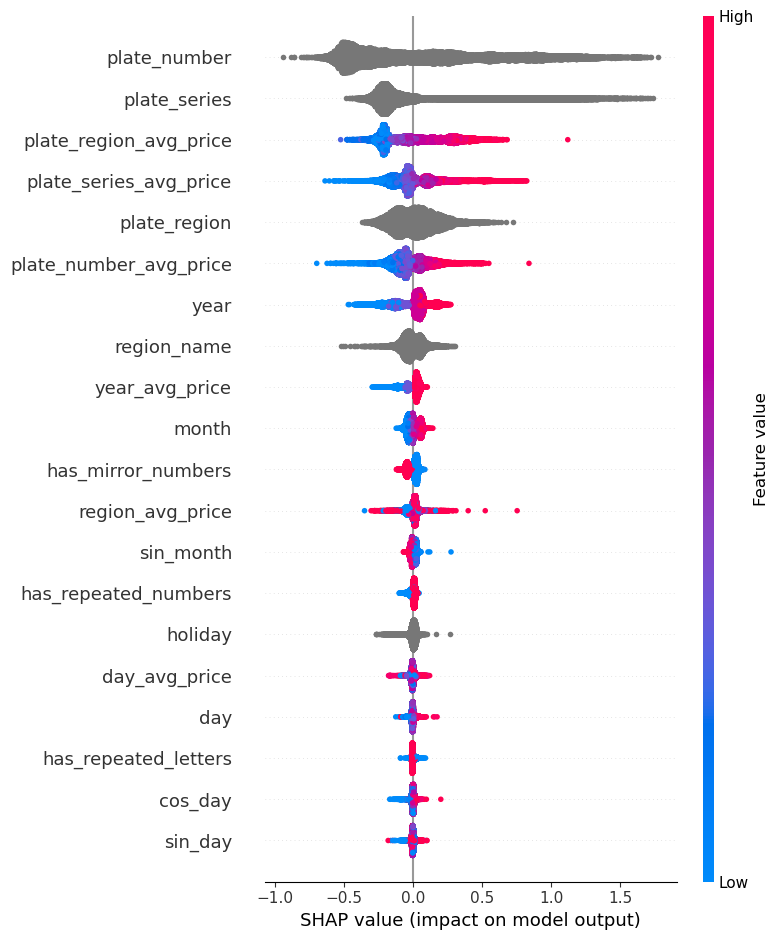

Selected top features based on SHAP values: ['plate_number', 'plate_series', 'plate_region_avg_price', 'plate_series_avg_price', 'plate_region', 'plate_number_avg_price', 'year', 'region_name', 'year_avg_price', 'month', 'has_mirror_numbers', 'region_avg_price', 'sin_month', 'has_repeated_numbers', 'holiday']


In [170]:
import shap
import catboost
import pandas as pd

# Assuming `model` is your trained CatBoost model
# Assuming `X_train` is your training data used for fitting the model

# Create a SHAP explainer for the CatBoost model
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the training data
shap_values = explainer.shap_values(X_train)

# Plot the summary plot to visualize feature importance
shap.summary_plot(shap_values, X_train)

# You can also print feature importance based on SHAP values
# Create a DataFrame for easy visualization of feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(shap_values).mean(axis=0)})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select top N features based on SHAP values
top_n = 15  # You can adjust the number of features you want
selected_features = importance_df.head(top_n)['Feature'].tolist()

print("Selected top features based on SHAP values:", selected_features)

In [171]:

# Filter the original data to include only the selected features
X_train_filtered = X_train[selected_features]
X_val_filtered = X_val[selected_features]

# Create new Pools for the filtered data
train_pool_filtered = Pool(data=X_train_filtered, label=y_train, cat_features=cat_features)
val_pool_filtered = Pool(data=X_val_filtered, label=y_val, cat_features=cat_features)

# Train CatBoost model again with the filtered features
model_filtered = CatBoostRegressor(
    iterations=10000,
  #  depth=6,
  #  learning_rate=0.1,
    loss_function='MAE',
    verbose=100,
)

# Fit the model on the filtered features
model_filtered.fit(train_pool_filtered, eval_set=val_pool_filtered, early_stopping_rounds=300)

# Predict and evaluate on the filtered features
y_pred_train_filtered = model_filtered.predict(X_train_filtered)
y_pred_val_filtered = model_filtered.predict(X_val_filtered)

# Evaluate SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

print(f"Train SMAPE with filtered features: {smape(y_train, y_pred_train_filtered):.2f}%")
print(f"Validation SMAPE with filtered features: {smape(y_val, y_pred_val_filtered):.2f}%")

0:	learn: 0.9088829	test: 0.9147841	best: 0.9147841 (0)	total: 14.1ms	remaining: 2m 21s
100:	learn: 0.4761877	test: 0.4777699	best: 0.4777699 (100)	total: 1.07s	remaining: 1m 45s
200:	learn: 0.4453286	test: 0.4483116	best: 0.4483116 (200)	total: 2.22s	remaining: 1m 48s
300:	learn: 0.4322365	test: 0.4355509	best: 0.4355509 (300)	total: 3.45s	remaining: 1m 51s
400:	learn: 0.4230162	test: 0.4275554	best: 0.4275554 (400)	total: 4.63s	remaining: 1m 50s
500:	learn: 0.4154512	test: 0.4210952	best: 0.4210952 (500)	total: 5.82s	remaining: 1m 50s
600:	learn: 0.4100776	test: 0.4169067	best: 0.4169067 (600)	total: 6.99s	remaining: 1m 49s
700:	learn: 0.4061464	test: 0.4140884	best: 0.4140884 (700)	total: 8.15s	remaining: 1m 48s
800:	learn: 0.4028718	test: 0.4120612	best: 0.4120612 (800)	total: 9.3s	remaining: 1m 46s
900:	learn: 0.3998916	test: 0.4101878	best: 0.4101878 (900)	total: 10.5s	remaining: 1m 46s
1000:	learn: 0.3974541	test: 0.4090272	best: 0.4090272 (1000)	total: 11.7s	remaining: 1m 45s
1

In [172]:
train_df.nunique()

price                      798
year                         5
month                       12
day                         31
weekday                      7
holiday                     26
advantage_on_road            2
significance                 8
region_name                 81
plate_number               999
plate_series              1728
plate_region               145
plate_series_avg_price    1692
plate_number_avg_price     973
plate_region_avg_price     145
significance_avg_price       8
year_avg_price               5
month_avg_price             12
day_avg_price               31
weekday_avg_price            7
region_avg_price            81
sin_month                   11
cos_month                   12
sin_weekday                  7
cos_weekday                  7
sin_day                     31
cos_day                     27
is_prestigious_number        1
is_prestigious_letter        2
has_repeated_letters         2
has_repeated_numbers         2
has_sequential_numbers       2
has_mirr

In [173]:
len(train_df.columns)

33

# Generate Prediction

In [161]:
import pandas as pd
import numpy as np
from catboost import Pool

# Load test dataset
test_raw = pd.read_csv(
    "datasets/test.csv",
    dtype={"id": int, "plate": str},
    parse_dates=["date"]
)

test_ids = test_raw["id"].copy()

# Preprocess test data
xgb_df_test = process_data_1("datasets/test.csv")
test_df = process_data_2(
    xgb_df_test,
    region_avg_price_dict,
    plate_series_avg_price_dict,
    plate_number_avg_price_dict,
    plate_region_avg_price_dict,
    significance_avg_price_dict,
    year_avg_price_dict,
    month_avg_price_dict,
    day_avg_price_dict,
    weekday_avg_price_dict
)

test_df = add_sin_cos_for_date_features(test_df)
test_df = process_data_4(test_df)
#test_df = add_external_data(test_df)

In [162]:
test_df

,price,year,month,day,weekday,holiday,advantage_on_road,significance,region_name,plate_number,...,sin_weekday,cos_weekday,sin_day,cos_day,is_prestigious_number,is_prestigious_letter,has_repeated_letters,has_repeated_numbers,has_sequential_numbers,has_mirror_numbers
0,NaN,2025,1,27,0,None,0,0,Moscow Oblast,700,...,0.000000,1.000000,-0.724793,0.688967,0,0,True,True,False,False
1,NaN,2025,2,10,0,None,0,0,Moscow,081,...,0.000000,1.000000,0.897805,-0.440394,0,0,False,False,False,False
2,NaN,2025,2,11,1,None,0,0,Moscow,333,...,0.781831,0.623490,0.790776,-0.612106,0,0,True,True,False,True
3,NaN,2025,2,3,0,None,0,0,Moscow,744,...,0.000000,1.000000,0.571268,0.820763,0,0,True,True,False,False
4,NaN,2025,2,12,2,None,0,0,Moscow,066,...,0.974928,-0.222521,0.651372,-0.758758,0,0,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7690,NaN,2023,3,13,0,None,0,0,Moscow,799,...,0.000000,1.000000,0.485302,-0.874347,0,0,True,True,False,False
7691,NaN,2022,10,19,2,None,0,0,Moscow,077,...,0.974928,-0.222521,-0.651372,-0.758758,0,0,True,True,False,False
7692,NaN,2023,10,2,0,None,0,0,Moscow,200,...,0.000000,1.000000,0.394356,0.918958,0,0,True,True,False,False
7693,NaN,2025,1,12,6,None,0,0,Moscow,073,...,-0.781831,0.623490,0.651372,-0.758758,0,1,False,False,False,False


In [163]:

# Ensure the same features as training
X_test = test_df

# Match categorical columns
cat_features = X_test.select_dtypes(include='object').columns.tolist()

# Create CatBoost Pool
test_pool = Pool(data=X_test, cat_features=cat_features)

# Make predictions
test_pred = model_filtered.predict(test_pool)

# If you used log1p transformation during training, reverse it
test_pred = np.round(np.expm1(test_pred))  # remove if not using log-transformed targets

# Build submission
submission = pd.DataFrame({
    'id': test_ids,
    'price': test_pred
})

submission.to_csv('submission1.csv', index=False)
print('✅ Done producing submission1.csv')


TypeError: must be real number, not NoneType

In [133]:
len(test_df.columns)

32

In [134]:
set(train_df.columns) - set(test_df.columns) 

set()

In [135]:
missing_columns = test_df.isna().sum()[test_df.isna().sum() > 0]
print(missing_columns)

price    7695
dtype: int64


In [136]:
train_df['date'] = pd.to_datetime(train_df['year'].astype(str) + '-' + train_df['month'].astype(str) + '-' + train_df['day'].astype(str))
print("train dates:", train_df['date'].min(), train_df['date'].max())
train_df = train_df.drop(columns=['date'])
train_df = train_df.drop(columns=['year', 'month', 'day'])
test_df['date'] = pd.to_datetime(test_df['year'].astype(str) + '-' + test_df['month'].astype(str) + '-' + test_df['day'].astype(str))
print("test dates:", test_df['date'].min(), test_df['date'].max())
test_df = test_df.drop(columns=['year', 'month', 'day'])

train dates: 2021-02-17 00:00:00 2025-02-12 00:00:00
test dates: 2021-02-17 00:00:00 2025-02-12 00:00:00


In [137]:
xgb_df_test

,price,year,month,day,weekday,advantage_on_road,significance,region_name,plate_number,plate_series,...,cos_weekday,sin_day,cos_day,is_prestigious_number,is_prestigious_letter,has_repeated_letters,has_repeated_numbers,has_sequential_numbers,has_mirror_numbers,date
0,NaN,2025,1,27,0,0,0,Moscow Oblast,700,PTT,...,1.000000,-0.724793,0.688967,0,0,True,True,False,False,2025-01-27
1,NaN,2025,2,10,0,0,0,Moscow,081,MTX,...,1.000000,0.897805,-0.440394,0,0,False,False,False,False,2025-02-10
2,NaN,2025,2,11,1,0,0,Moscow,333,THX,...,0.623490,0.790776,-0.612106,0,0,True,True,False,True,2025-02-11
3,NaN,2025,2,3,0,0,0,Moscow,744,HBH,...,1.000000,0.571268,0.820763,0,0,True,True,False,False,2025-02-03
4,NaN,2025,2,12,2,0,0,Moscow,066,XEM,...,-0.222521,0.651372,-0.758758,0,0,True,True,False,False,2025-02-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7690,NaN,2023,3,13,0,0,0,Moscow,799,XCC,...,1.000000,0.485302,-0.874347,0,0,True,True,False,False,2023-03-13
7691,NaN,2022,10,19,2,0,0,Moscow,077,KYT,...,-0.222521,-0.651372,-0.758758,0,0,True,True,False,False,2022-10-19
7692,NaN,2023,10,2,0,0,0,Moscow,200,OPA,...,1.000000,0.394356,0.918958,0,0,True,True,False,False,2023-10-02
7693,NaN,2025,1,12,6,0,0,Moscow,073,OOO,...,0.623490,0.651372,-0.758758,0,1,False,False,False,False,2025-01-12


In [138]:
xgb_df_test['advantage_on_road'].unique()

array([0, 1])

**Now it is your turn to beat this 🚗💨**

![fun-image](https://media4.giphy.com/media/v1.Y2lkPTc5MGI3NjExeDR5MDI3aTVkM2ozanJ6d2ttc3ppdjh4M2owM2d1czRqaWZ0dWNjeSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/11V6rs3BsLzVcs/giphy.gif)

In [139]:
min(test_data['date']), max(test_data['date'])

NameError: name 'test_data' is not defined

In [ ]:
test_data

,price,year,month,day,weekday,advantage_on_road,significance,region_name,plate_number,plate_series,plate_region,region_avg_price
0,NaN,2025,1,27,0,0,0,Moscow Oblast,700,PTT,790,12.689147
1,NaN,2025,2,10,0,0,0,Moscow,081,MTX,797,13.156570
2,NaN,2025,2,11,1,0,0,Moscow,333,THX,777,13.156570
3,NaN,2025,2,3,0,0,0,Moscow,744,HBH,977,13.156570
4,NaN,2025,2,12,2,0,0,Moscow,066,XEM,777,13.156570
...,...,...,...,...,...,...,...,...,...,...,...,...
7690,NaN,2023,3,13,0,0,0,Moscow,799,XCC,799,13.156570
7691,NaN,2022,10,19,2,0,0,Moscow,077,KYT,777,13.156570
7692,NaN,2023,10,2,0,0,0,Moscow,200,OPA,777,13.156570
7693,NaN,2025,1,12,6,0,0,Moscow,073,OOO,097,13.156570


In [ ]:
xgb_df_test['year'].min()

2021